# **Basic CNN**

In [ ]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 818.9/818.9 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import lightning as L
import torchmetrics

class BasicCNN(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc_layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.train_losses.append(loss.item())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.val_losses.append(loss.item())
        self.log("val_loss", loss)
        self.log("val_accuracy", acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("test_loss", loss)
        self.log("test_accuracy", acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [ ]:
from torchvision import transforms
from torchvision.datasets import Imagenette
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint



train_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    transforms.Grayscale()
])

test_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    transforms.Grayscale()
])

train_dataset = Imagenette("data/imagenette/train/", split="train", size="160px", download=True, transform=train_transforms)


train_set_size = int(len(train_dataset) * 0.9)
val_set_size = len(train_dataset) - train_set_size

seed = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_set_size, val_set_size], generator=seed)
val_dataset.dataset.transform = test_transforms


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, num_workers=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, num_workers=8, shuffle=False)

test_dataset = Imagenette("data/imagenette/test/", split="val", size="160px", download=True, transform=test_transforms)

model = BasicCNN()

early_stop_callback = EarlyStopping(monitor="val_loss",
                                    mode="min",
                                    patience=5)


checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    mode="min"
)

100%|██████████| 99.0M/99.0M [00:06<00:00, 14.2MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 99.0M/99.0M [00:08<00:00, 12.0MB/s]


In [ ]:
trainer = L.Trainer(callbacks=[early_stop_callback, checkpoint_callback], max_epochs=30)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | conv_layers | Sequential         | 92.7 K | train
1 | fc_layers   | Sequential         | 2.1 M  | train
2 | accuracy    | MulticlassAccuracy | 0      | train
-----------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.771     Total estimated model params size (MB)
16        Modules

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, num_workers=8, shuffle=False)
trainer.test(model=model, dataloaders=test_loader)

train_loss_per_epoch = [
    sum(model.train_losses[i:i+len(train_loader)]) / len(train_loader)
    for i in range(0, len(model.train_losses), len(train_loader))
]

val_loss_per_epoch = [
    sum(model.val_losses[i:i+len(val_loader)]) / len(val_loader)
    for i in range(0, len(model.val_losses), len(val_loader))
]

final_train_loss = train_loss_per_epoch[-1]
final_val_loss = val_loss_per_epoch[-1]

print(f"Training Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")



INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.6308280229568481     │
│         test_loss         │     1.55498206615448      │
└───────────────────────────┴───────────────────────────┘

Training Loss: 0.2346
Validation Loss: 0.3145


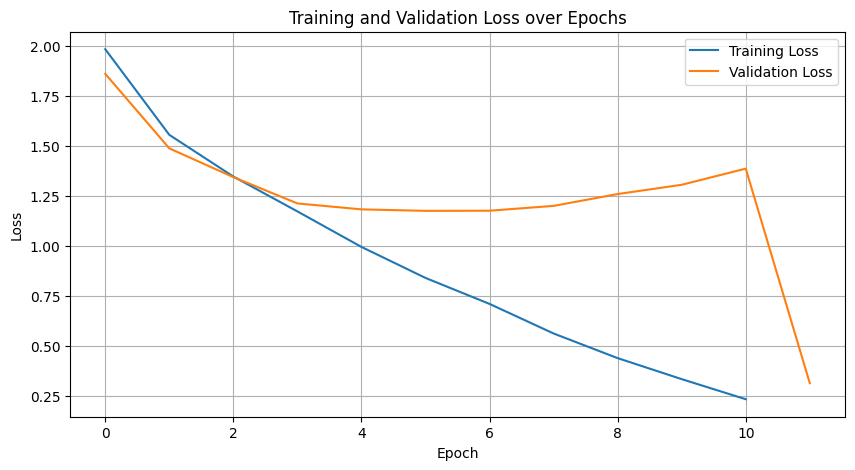

In [ ]:
import matplotlib.pyplot as plt


def plot_losses(model):

    train_loss_per_epoch = [sum(model.train_losses[i:i+len(train_loader)]) / len(train_loader)
                            for i in range(0, len(model.train_losses), len(train_loader))]
    val_loss_per_epoch = [sum(model.val_losses[i:i+len(val_loader)]) / len(val_loader)
                          for i in range(0, len(model.val_losses), len(val_loader))]

    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_per_epoch, label="Training Loss")
    plt.plot(val_loss_per_epoch, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_losses(model)

# Basic CNN Architecture

 -> Input: Grayscale image, resized to 64x64 pixels

 -> Convolutional Layer 1: 32 filters, 3×3 kernel, stride 1, padding 1 → ReLU → MaxPooling (2×2)

-> Convolutional Layer 2: 64 filters, 3×3 kernel, stride 1, padding 1 → ReLU MaxPooling (2×2)

-> Convolutional Layer 3: 128 filters, 3×3 kernel, stride 1, padding 1 → ReLU → MaxPooling (2×2)

-> Flatten Layer

-> Fully Connected Layer 1: 256 units → ReLU → Dropout (0.3)

-> Fully Connected Layer 2: Linear output layer with 10 classes (one per class in Imagenette)

# Training Summary

The model was trained using the Imagenette dataset with grayscale preprocessing and resized input. Training and validation loss were tracked over time, showing consistent convergence. Final evaluation was done using the test set.

Training Loss: 0.2346

Validation Loss: 0.3145

Final Test Accuracy:  0.6308